In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

In [2]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)



In [3]:
regressors = [
    'xgbregressor', 
    'lgbmregressor', 
    'catregressor', 
    #'lassocvregressor',
    #'tfregressor',
]

In [4]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
target = ['Class']

In [5]:
# Join oof preds
oof_df = pd.DataFrame(index=np.arange(len(train_df.index)))
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_train_submission.csv", index_col=0)
    df.rename(columns={target[0]: i}, inplace=True)
    oof_df = pd.concat([oof_df,df], axis=1)
    
# Join test preds
test_preds = pd.DataFrame()
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_test_submission.csv", index_col=0)
    df.rename(columns={target[0]: i}, inplace=True)
    test_preds = pd.concat([test_preds,df], axis=1)
    
oof_df.head(3)

,xgbregressor,lgbmregressor,catregressor
0,0.001121,0.001129,0.000675
1,0.000843,0.000718,0.002672
2,0.001237,0.001156,0.001010


In [6]:
oof_df.describe()

,xgbregressor,lgbmregressor,catregressor
count,219129.000000,219129.000000,219129.000000
mean,0.002121,0.002038,0.002111
std,0.009842,0.010022,0.011050
min,0.000193,0.000216,-0.013780
25%,0.000651,0.000543,0.000661
50%,0.001077,0.000905,0.001224
75%,0.001848,0.001642,0.002060
max,0.847340,0.756317,0.886823


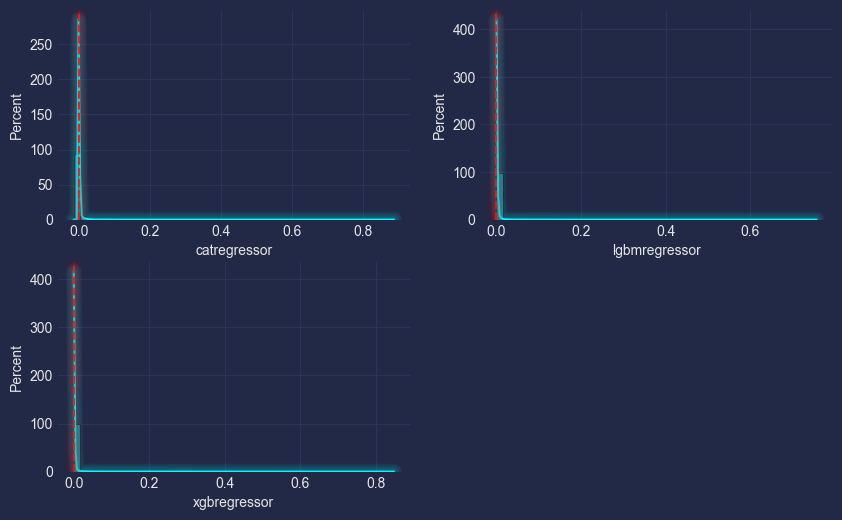

In [7]:
import math
plt.style.use("cyberpunk")
features = oof_df.columns

n_cols = 2
n_rows = math.ceil(len(features) / n_cols)
cell_with_dim = 5
cell_height_dim = 3

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
    a.axis('off')


for i, column in enumerate(oof_df.columns):
    
    row = math.ceil(i / n_cols) - 1
    col = (i % n_cols)
    
    sns.histplot(oof_df[column], **histplot_hyperparams, ax=ax[row, col])
    ax[row, col].axvline(x = 0, color = 'r', linestyle='--')
    mplcyberpunk.make_lines_glow(ax[row, col])


plt.show()

In [8]:
features

Index(['xgbregressor', 'lgbmregressor', 'catregressor'], dtype='object')

In [9]:
ax

array([[<AxesSubplot: xlabel='catregressor', ylabel='Percent'>,
        <AxesSubplot: xlabel='lgbmregressor', ylabel='Percent'>],
       [<AxesSubplot: xlabel='xgbregressor', ylabel='Percent'>,
        <AxesSubplot: >]], dtype=object)

In [10]:
# Evaluate oof preds
scores = {}
for col in oof_df.columns:
    scores[col] = roc_auc_score(train_df[target], oof_df[col])

# Sort scores
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

# Sort oof_df and test_preds
oof_df = oof_df[list(scores.keys())]
test_preds = test_preds[list(scores.keys())]

scores

{'lgbmregressor': 0.9271291099090271,
 'xgbregressor': 0.8884254395399621,
 'catregressor': 0.8443083448576199}

In [11]:
#MODELS['tfregressor'] = MODELS['tfregressor'].astype('float')

In [12]:
# Initialise
STOP = False
current_best_ensemble = oof_df.iloc[:,0].copy()
current_best_test_preds = test_preds.iloc[:,0].copy()
MODELS = oof_df.iloc[:,0:].copy()
history = []
history_names = []
i=0

# Hill climbing
while not STOP:
    i+=1
    potential_new_best_cv_score = roc_auc_score(train_df[target], current_best_ensemble)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in np.arange(-0.5,0.51,0.01):
            potential_ensemble = (1-wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(train_df[target], potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt
            
    if k_best is not None:
        current_best_ensemble = (1-wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        current_best_test_preds = (1-wgt_best) * current_best_test_preds + wgt_best * test_preds[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1]==0:
            STOP = True
        print(f'Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}')
        history_names.append(k_best)
        history.append(potential_new_best_cv_score)
    else:
        STOP = True

Iteration: 1, Model added: xgbregressor, Best weight: -0.10, Best AUC: 0.92772
Iteration: 2, Model added: lgbmregressor, Best weight: 0.02, Best AUC: 0.92772
Iteration: 3, Model added: catregressor, Best weight: 0.00, Best AUC: 0.92772


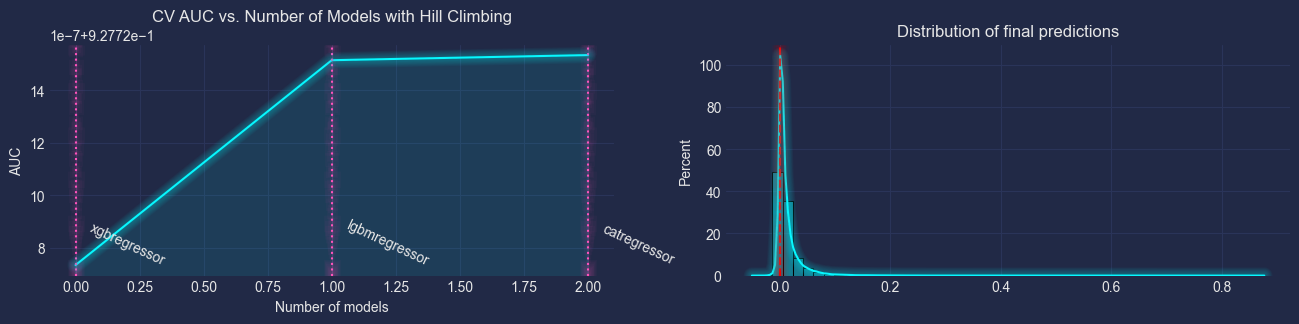

In [13]:
plt.style.use("cyberpunk")

n_cols = 2
n_rows = 1
cell_with_dim = 8
cell_height_dim = 3

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
sns.lineplot(history, ax=ax[0])
sns.histplot(current_best_test_preds, **histplot_hyperparams, ax=ax[1])

ylim = ax[0].get_ylim()

for i, auc in enumerate(history):
    ax[0].axvline(x = i, color = '#FE53BB', linestyle=':')
    ax[0].text(i + 0.05, ylim[0] + ((ylim[0] - ylim[1] ) * -0.05), history_names[i], fontsize=10, rotation=-25)

ax[0].set_ylim(ylim)


ax[1].axvline(x = 0, color = 'r', linestyle='--')

mplcyberpunk.make_lines_glow(ax[0])
mplcyberpunk.add_underglow(ax[0])
mplcyberpunk.make_lines_glow(ax[1])

ax[0].set_title("CV AUC vs. Number of Models with Hill Climbing")
ax[0].set_xlabel("Number of models")
ax[0].set_ylabel("AUC")
ax[1].set_title("Distribution of final predictions")


plt.show()

In [14]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2', '3', '4']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        #sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

In [15]:
model_list = oof_df.iloc[:,0:].copy()

for reg in regressors:
    train_df[reg] = model_list[reg]

In [16]:
train_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,xgbregressor,lgbmregressor,catregressor
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,...,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,0.001121,0.001129,0.000675
1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,...,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,0.000843,0.000718,0.002672
2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,...,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0,0.001237,0.001156,0.001010
3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,...,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0,0.001137,0.000763,0.000892
4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,...,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0,0.002060,0.002678,0.001676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219124,120580.0,1.891079,-1.272908,-3.783908,-1.388939,2.012789,2.666080,0.151740,0.401934,-1.102824,...,0.756765,0.244479,-0.147566,-0.054725,-0.044588,198.65,0,0.002262,0.001743,0.002405
219125,120580.0,0.139724,0.948649,-2.913655,-2.184829,1.883716,-1.056824,1.725624,0.018089,-0.823494,...,-0.091409,-1.053488,0.467570,0.358918,0.294735,24.00,0,0.000984,0.001854,0.005269
219126,120580.0,2.058343,-0.038993,-1.928553,0.330117,0.270127,-0.735664,-0.173878,0.144823,0.849289,...,-0.021434,-0.343989,0.181065,-0.098387,-0.044064,1.79,0,0.002508,0.003105,0.002167


In [17]:
#render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0]] + regressors)

In [18]:
# Submit predictions
submission = sub.copy()
submission[target[0]] = current_best_test_preds.values
submission.to_csv("submission.csv", index=True)